In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from datetime import datetime
from scipy import stats
import scipy.optimize

from os import listdir
from os.path import isfile, join

from MSsmoothing import smoothMS

import pandas as pd
import csv

rootfolder="/home/aulegoup/Optical_fibers/Absorption_spectra_experiments/"

In [2]:
FILES=[
        {'NameFoldExtract':"2024-08-04 - Sample 1 TA cycling 270K 5uW",
        'NameSubFoldTemp':"Temperature data",
        'NameCSVforTemp':"2024-08-04 Sun 10h04min45s - fiber T curve - dur 23211s.csv",
        'firstfilenb':0,
        'samplelength':41.4, #m
        'sweepperiod':2.261}, #s #program SWEEPMID0
    
        {'NameFoldExtract':"2024-08-06 - Sample 1 TA slow 5uW",
        'NameSubFoldTemp':"Temperature data",
        'NameCSVforTemp':"2024-08-06 Tue 13h05min12s - fiber T curve - dur 80589s.csv",
        'firstfilenb':0,
        'samplelength':41.4, #m
        'sweepperiod':2.261}, #s #program SWEEPMID0
    
        {'NameFoldExtract':"2024-08-07 - Sample 1 TA slow 5uW 2",
        'NameSubFoldTemp':"Temperature data",
        'NameCSVforTemp':"2024-08-07 Wed 11h46min54s - fiber T curve - dur 104320s.csv",
        'firstfilenb':0,
        'samplelength':41.4, #m
        'sweepperiod':2.261}, #s #program SWEEPMID0

]


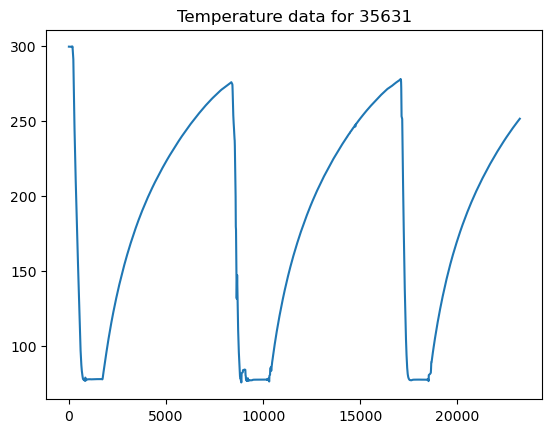

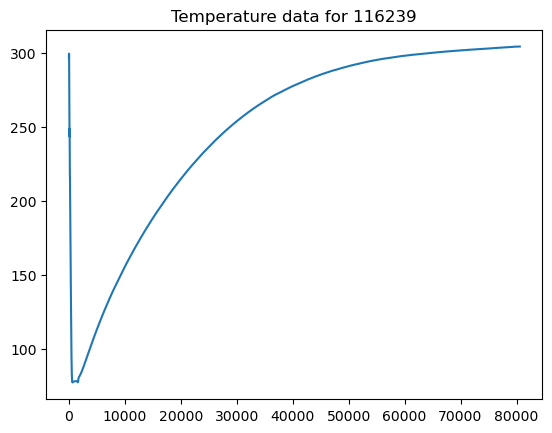

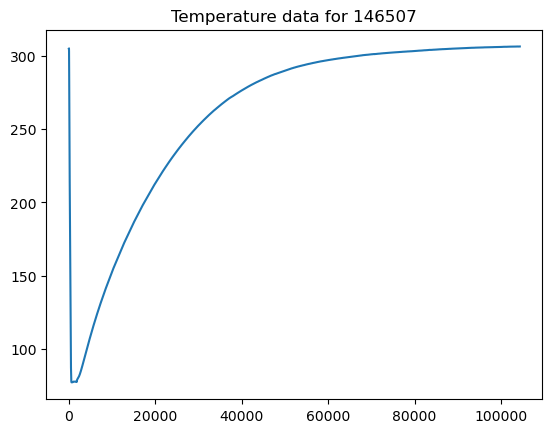

In [5]:
#######################################################################################################
#Let's extract the temperature data:
#######################################################################################################
TEMPFILES=[]
for j,dicfile in enumerate(FILES):
    mypath=join(rootfolder,dicfile["NameFoldExtract"])
    Tpath=join(join(mypath,dicfile['NameSubFoldTemp']),dicfile['NameCSVforTemp'])
    with open(Tpath,'r') as f:
        LINES_T=f.readlines()
        N_T=len(LINES_T)
        TIME_T,TEMP=[],[]
        for i in range(N_T):
            l=LINES_T[i]
            if '.' in l:
                sec,temp=float((l.split(','))[0]),float((l.split(','))[1])
                if temp>75 and (i==0 or np.abs(temp-TEMP[-1])<35):
                    TIME_T+=[sec]
                    TEMP+=[temp]
    TEMP = smoothMS(TEMP,n=6,m=200)
    plt.plot(TIME_T,TEMP)
    plt.title(f"Temperature data for {i}")
    plt.show()
    TEMPFILES+=[{
        "TIME_T":np.array(TIME_T),
        "TEMP":np.array(TEMP),
    }]
    
def TimetoTemp(t,idfile,mode="id"):
    if mode=="id":
        return next(x for x,sec in enumerate(TEMPFILES[idfile]["TIME_T"]) if sec>t)
    elif mode=="temp":
        return np.interp(t,TEMPFILES[idfile]["TIME_T"], TEMPFILES[idfile]["TEMP"])

78.02628214879789 6619.561


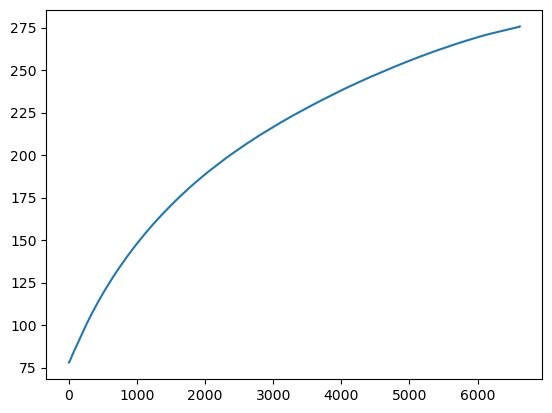

In [6]:
TIME_T,TEMP = TEMPFILES[0]["TIME_T"][1370:6550],TEMPFILES[0]["TEMP"][1370:6550]
TIME_T = TIME_T-TIME_T[0]
# print(len(TEMP))
print(TEMP[0],TIME_T[-1])
plt.plot(TIME_T,TEMP)

In [7]:
df = pd.DataFrame({"Time (s)" : TIME_T, "Temperature (K)" : TEMP})
# df.to_csv("1stTA08-04.csv", index=False)

# Plot the results from COMSOL

In [8]:
Folder = "COMSOL_res"
SensorFile = "COMSOL-sensor.csv"
CavityFile = "COMSOL-CavityMax.csv"
InWallFile = "COMSOL-InnerwallAvg.csv"

In [37]:
DIC_COMSOL={}
for filename in [SensorFile, CavityFile, InWallFile]:
    with open(join(Folder,filename),'r') as f:
        Time,Temp=[],[]
        csvFile = csv.DictReader(f)
        for line in csvFile:
            l=list(line.values())
            if not('%' in l[0]):
                l=[float(e) for e in l]
                Time+=[l[0]]
                Temp+=[l[1]]
        DIC_COMSOL[filename]=(np.array(Time),np.array(Temp))

220.0 0.7416364148977408
220.0 8.113147584523475


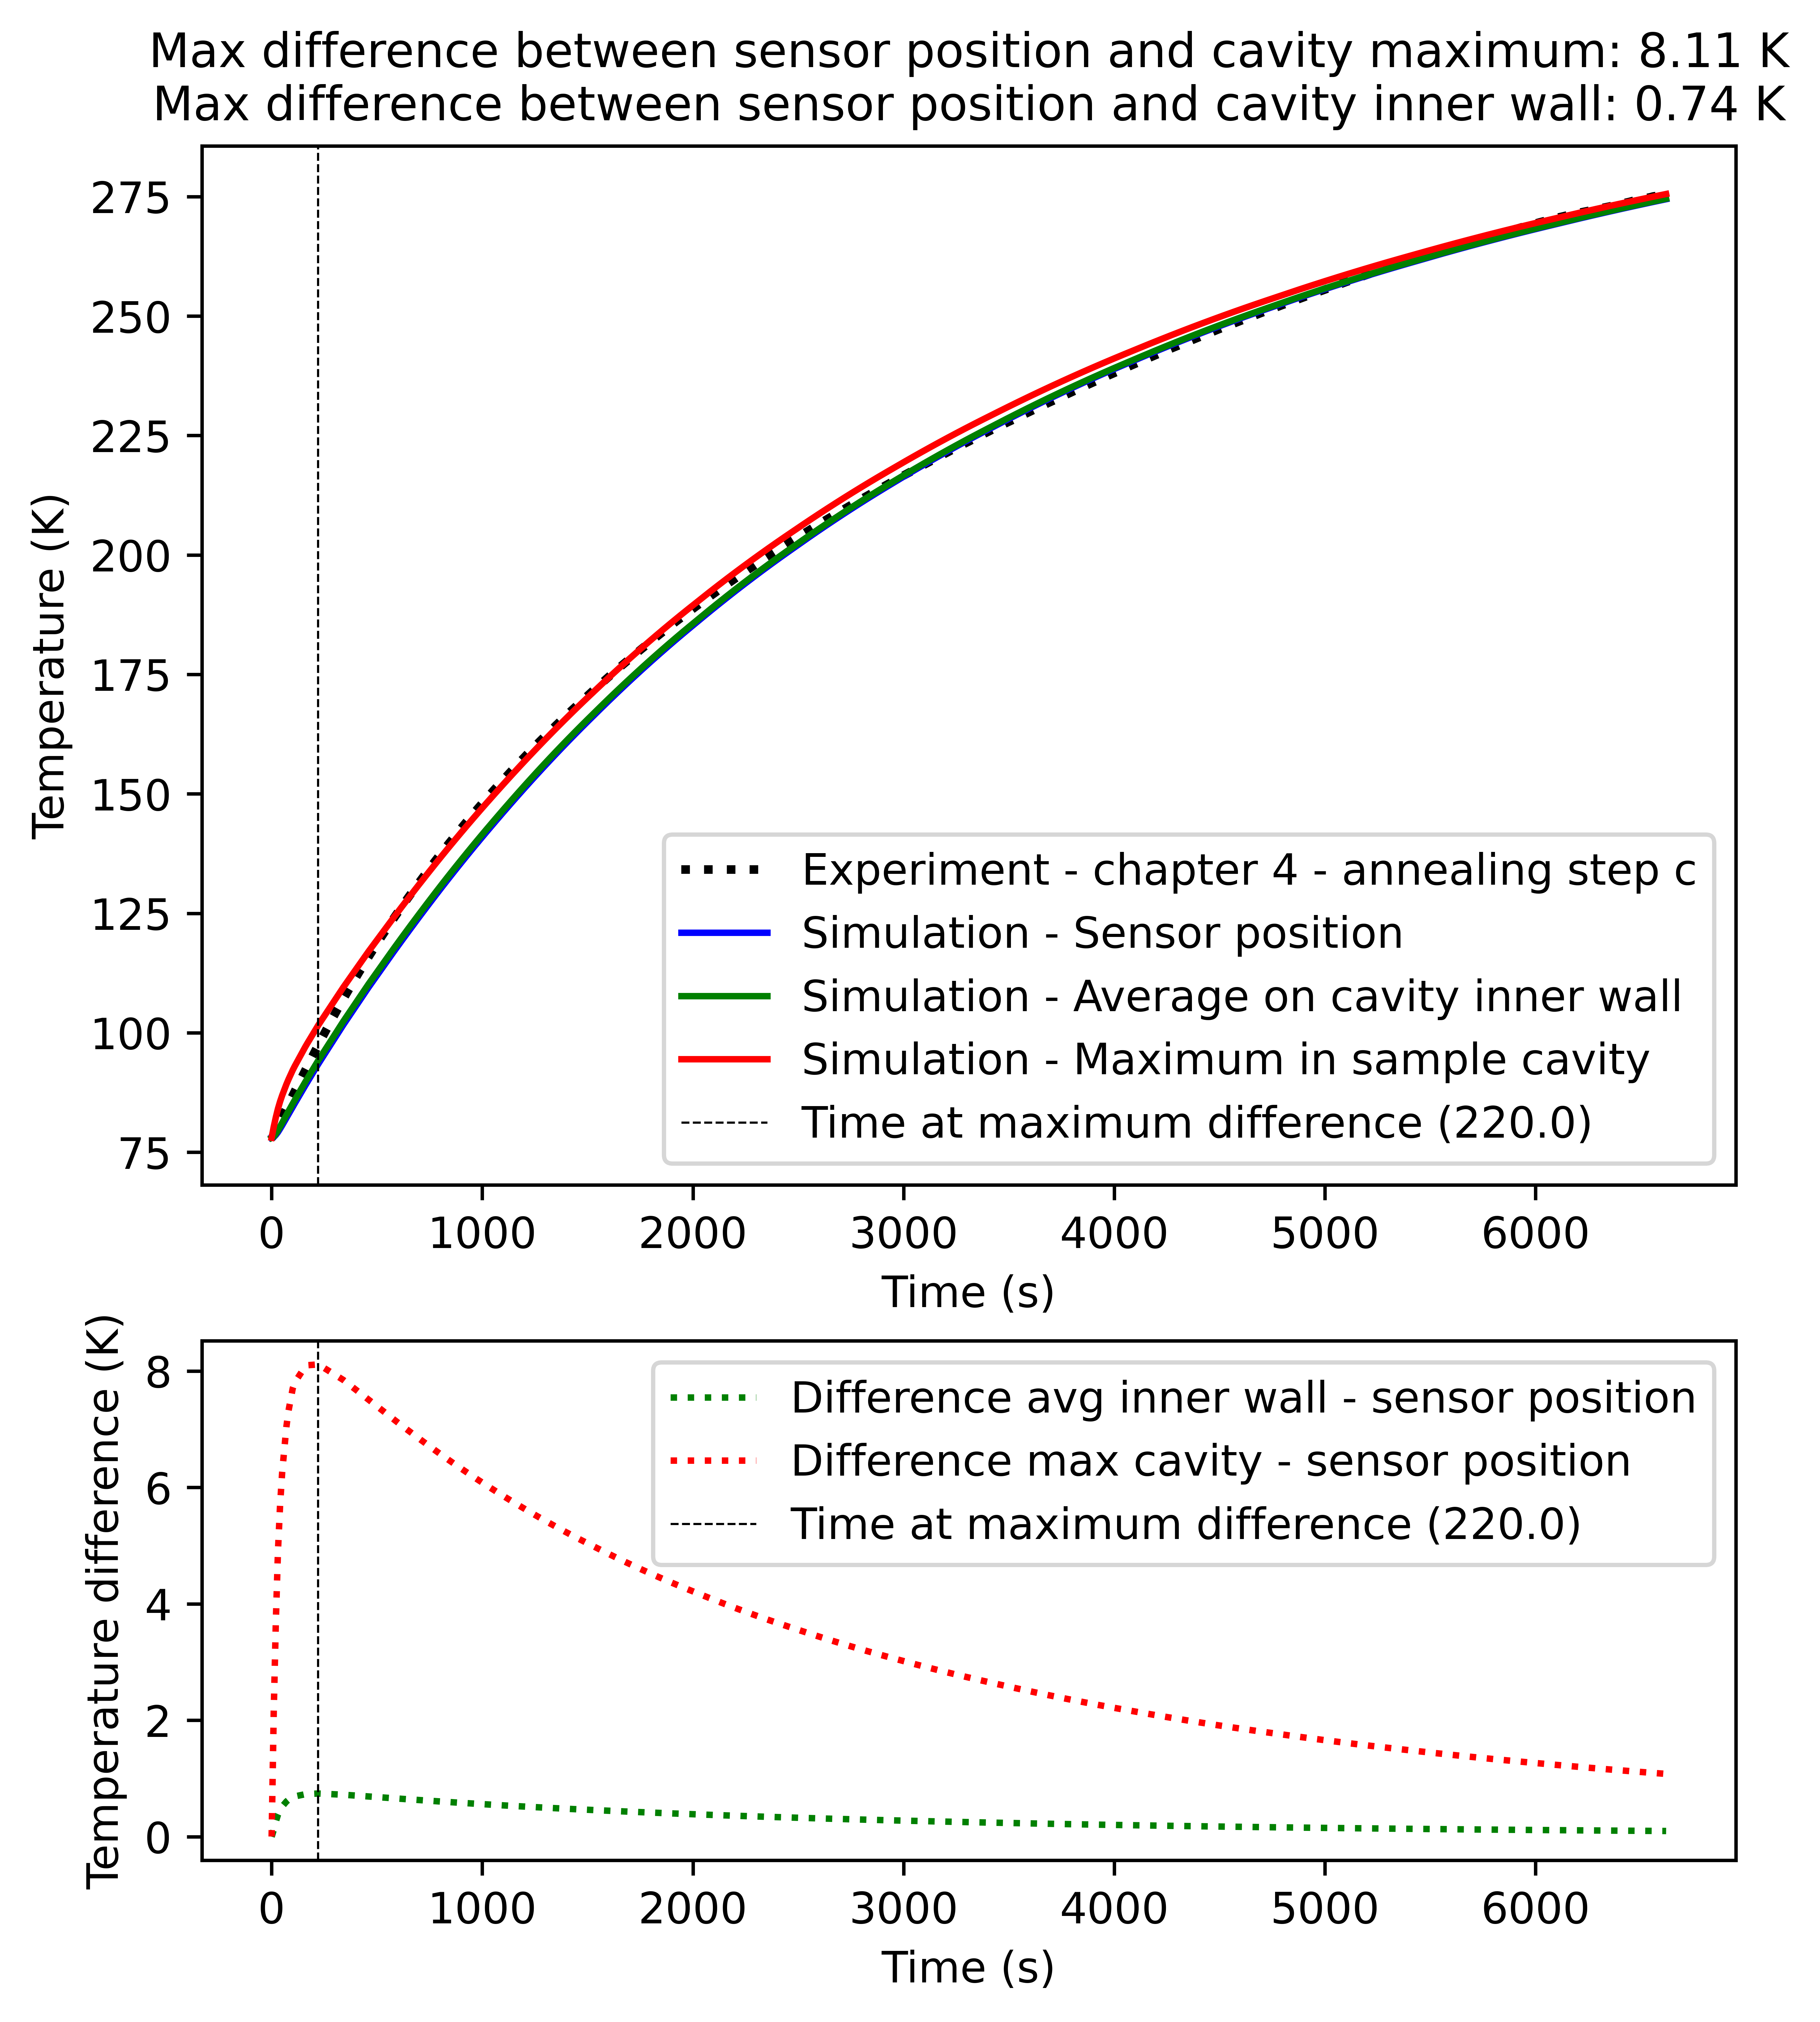

In [69]:
fig, axs = plt.subplots(2, figsize=[6.4, 4.8*1.5], gridspec_kw={'height_ratios': [2, 1]})
fig.set_dpi(1000)

maxinwalldiff=np.max(DIC_COMSOL[InWallFile][1]-DIC_COMSOL[SensorFile][1])
maxcavitydiff=np.max(DIC_COMSOL[CavityFile][1]-DIC_COMSOL[SensorFile][1])
time_maxinwalldiff=DIC_COMSOL[SensorFile][0][np.argmax(DIC_COMSOL[InWallFile][1]-DIC_COMSOL[SensorFile][1])]
time_maxcavitydiff=DIC_COMSOL[SensorFile][0][np.argmax(DIC_COMSOL[CavityFile][1]-DIC_COMSOL[SensorFile][1])]
print(time_maxinwalldiff,maxinwalldiff)
print(time_maxcavitydiff,maxcavitydiff)


axs[0].plot(TIME_T,TEMP,linewidth=2,color='k',label='Experiment - chapter 4 - annealing step c',linestyle='dotted')#,marker='o',markersize='2')
axs[0].plot(*DIC_COMSOL[SensorFile],label="Simulation - Sensor position",color='blue')
axs[0].plot(*DIC_COMSOL[InWallFile],label="Simulation - Average on cavity inner wall",color='green')
axs[0].plot(*DIC_COMSOL[CavityFile],label="Simulation - Maximum in sample cavity",color='red')
axs[1].plot(DIC_COMSOL[CavityFile][0],DIC_COMSOL[InWallFile][1]-DIC_COMSOL[SensorFile][1],label="Difference avg inner wall - sensor position",linestyle='dotted',color='green')
axs[1].plot(DIC_COMSOL[CavityFile][0],DIC_COMSOL[CavityFile][1]-DIC_COMSOL[SensorFile][1],label="Difference max cavity - sensor position",linestyle='dotted',color='red')
axs[0].axvline(time_maxcavitydiff,label=f"Time at maximum difference ({time_maxcavitydiff})",color='k',linestyle='dashed',linewidth=0.5)
axs[1].axvline(time_maxcavitydiff,label=f"Time at maximum difference ({time_maxcavitydiff})",color='k',linestyle='dashed',linewidth=0.5)
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Time (s)")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Temperature (K)")
axs[1].set_ylabel("Temperature difference (K)")
axs[0].set_title(f"Max difference between sensor position and cavity maximum: {maxcavitydiff:.2f} K\n\
Max difference between sensor position and cavity inner wall: {maxinwalldiff:.2f} K",fontsize=11)
# plt.show()
plt.savefig("COMSOLplot.pdf",bbox_inches='tight')